## ДЗ 7
Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

Усреднить прогнозы с помощью арифметического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Выполнить задание 2 для трех моделей.

(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb
import xgboost as xgb
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import shap
from tqdm.notebook import tqdm

In [2]:
pd.options.display.max_rows = 222
pd.set_option("display.max_columns", 50)

Функции

In [3]:
def create_freq_feature(data: pd.DataFrame,
                        feature: str
                       ) -> pd.DataFrame:
    freq = data[feature].value_counts()
    data[feature] = data[feature].map(freq).astype('float')
    data[feature] = data[feature].fillna(0.0).astype('float')
    data[feature] = data[feature] / data.shape[0]
    
    return data

### Клиентский профиль
df_client_profile

In [4]:
# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile = pd.read_csv(
    "../geekbrains-competitive-data-analysis/client_profile.csv"
)

print("client_profile.shape = {} rows, {} cols".format(*df_client_profile.shape))
df_client_profile.head()

client_profile.shape = 250000 rows, 24 cols


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,365243,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [5]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

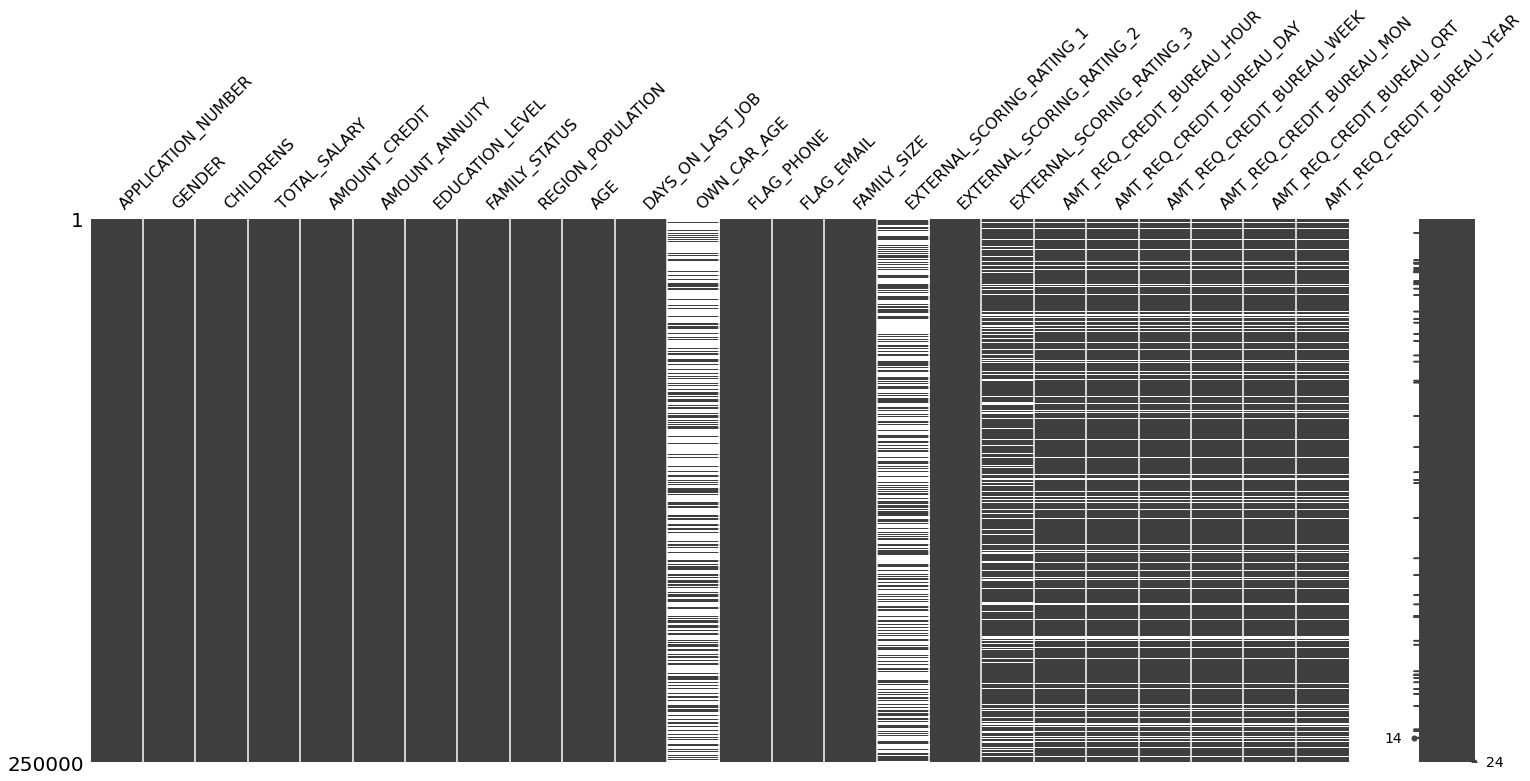

In [6]:
msno.matrix(df_client_profile)

GENDER

In [7]:
df_client_profile['GENDER'].value_counts()

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64

In [8]:
df_client_profile['GENDER'] = (df_client_profile['GENDER'] == 'F').astype(int)

FAMILY_STATUS,EDUCATION_LEVEL

In [9]:
df_client_profile['FAMILY_STATUS'].value_counts()

Married                 159846
Single / not married     36883
Civil marriage           24252
Separated                15984
Widow                    13033
Unknown                      2
Name: FAMILY_STATUS, dtype: int64

In [10]:
df_client_profile['EDUCATION_LEVEL'].value_counts()

Secondary / secondary special    177562
Higher education                  60864
Incomplete higher                  8357
Lower secondary                    3081
Academic degree                     136
Name: EDUCATION_LEVEL, dtype: int64

In [11]:
df_client_profile = create_freq_feature(df_client_profile, 'FAMILY_STATUS')
df_client_profile = create_freq_feature(df_client_profile, 'EDUCATION_LEVEL')

In [12]:
df_client_profile = df_client_profile.fillna(value=
                                             {'OWN_CAR_AGE': 0, 
                                              'EXTERNAL_SCORING_RATING_1': df_client_profile['EXTERNAL_SCORING_RATING_1'].min(),
                                              'EXTERNAL_SCORING_RATING_3': df_client_profile['EXTERNAL_SCORING_RATING_3'].min()
                                             })

df_client_profile = df_client_profile.fillna(0)

In [13]:
df_client_profile.describe().T

,count,mean,std,min,25%,50%,75%,max
APPLICATION_NUMBER,250000.0,1.235771e+08,88777.222374,1.234233e+08,1.235002e+08,1.235772e+08,1.236540e+08,1.237309e+08
GENDER,250000.0,6.585800e-01,0.474187,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CHILDRENS,250000.0,4.176240e-01,0.722529,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
TOTAL_SALARY,250000.0,1.690662e+05,258847.985752,2.565000e+04,1.125000e+05,1.485000e+05,2.025000e+05,1.170000e+08
AMOUNT_CREDIT,250000.0,5.993051e+05,402272.024068,4.500000e+04,2.700000e+05,5.147775e+05,8.086500e+05,4.050000e+06
AMOUNT_ANNUITY,250000.0,2.712402e+04,14504.727260,0.000000e+00,1.652400e+04,2.493000e+04,3.461400e+04,2.301615e+05
EDUCATION_LEVEL,250000.0,5.649927e-01,0.231384,5.440000e-04,2.434560e-01,7.102480e-01,7.102480e-01,7.102480e-01
FAMILY_STATUS,250000.0,4.467937e-01,0.257469,8.000000e-06,1.475320e-01,6.393840e-01,6.393840e-01,6.393840e-01
REGION_POPULATION,250000.0,2.087081e-02,0.013827,2.900000e-04,1.000600e-02,1.885000e-02,2.866300e-02,7.250800e-02
AGE,250000.0,1.603346e+04,4361.332320,7.489000e+03,1.241500e+04,1.574400e+04,1.968100e+04,2.522900e+04


# Модель

In [14]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 110093 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [15]:
df_test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash
...,...,...
165136,123487967,Cash
165137,123536402,Cash
165138,123718238,Cash
165139,123631557,Cash


In [16]:
df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

In [17]:
df_train = df_train.merge(df_client_profile, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_client_profile, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

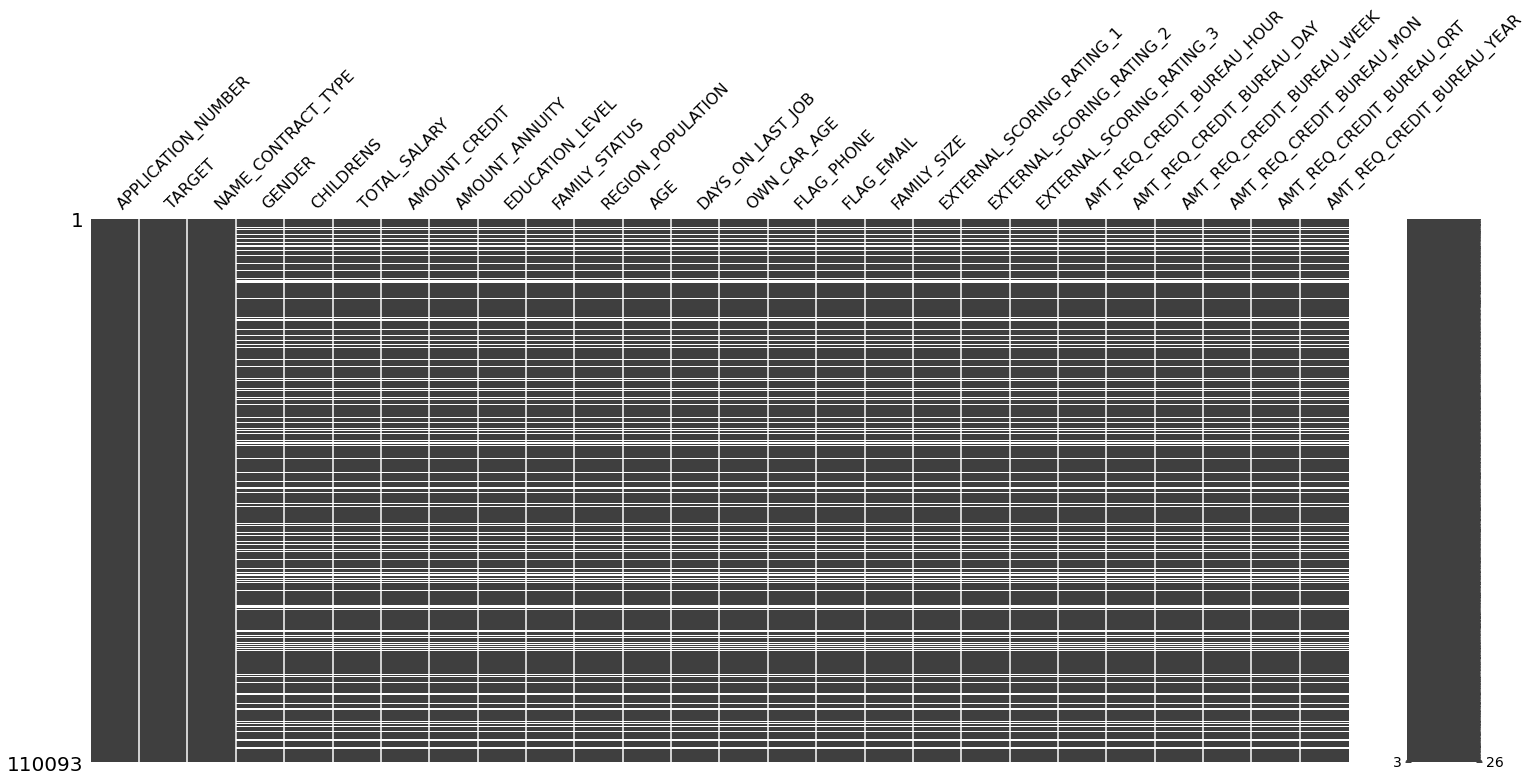

In [18]:
msno.matrix(df_train)

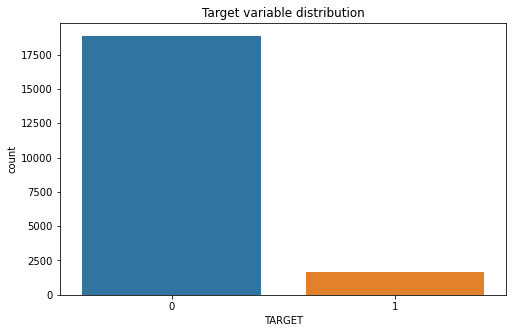

In [19]:
plt.figure(figsize=(8,5))

sns.countplot(x='TARGET',data=df_train.loc[df_train['AGE'].isnull(), :])
plt.title('Target variable distribution')

plt.show()

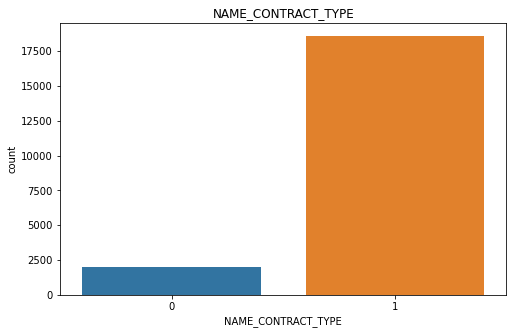

In [20]:
plt.figure(figsize=(8,5))

sns.countplot(x='NAME_CONTRACT_TYPE',data=df_train.loc[df_train['AGE'].isnull(), :])
plt.title('NAME_CONTRACT_TYPE')

plt.show()

In [21]:
FEATURE = df_train.columns
FEATURE = FEATURE.drop(['APPLICATION_NUMBER', 'TARGET'])
print(FEATURE)
TARGET = 'TARGET'

Index(['NAME_CONTRACT_TYPE', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')


In [22]:
df_train, df_valid = train_test_split(df_train, 
                                      test_size=0.3,  
                                      random_state=42)

In [23]:
%%time

dtrain = xgb.DMatrix(data=df_train[FEATURE], 
                     label=df_train[TARGET])
print('*')

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "reg_lambda": 100,
    "max_depth": 10,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, "train")],
    verbose_eval=200,
    maximize=True,
)

*
[0]	train-auc:0.53916
Will train until train-auc hasn't improved in 50 rounds.
[200]	train-auc:0.68618
[400]	train-auc:0.71226
[499]	train-auc:0.71878
Wall time: 56.8 s


In [24]:
x_valid_ = df_valid.sample(5000)
y_valid_ =  x_valid_[TARGET]
x_valid_ =  x_valid_[FEATURE]

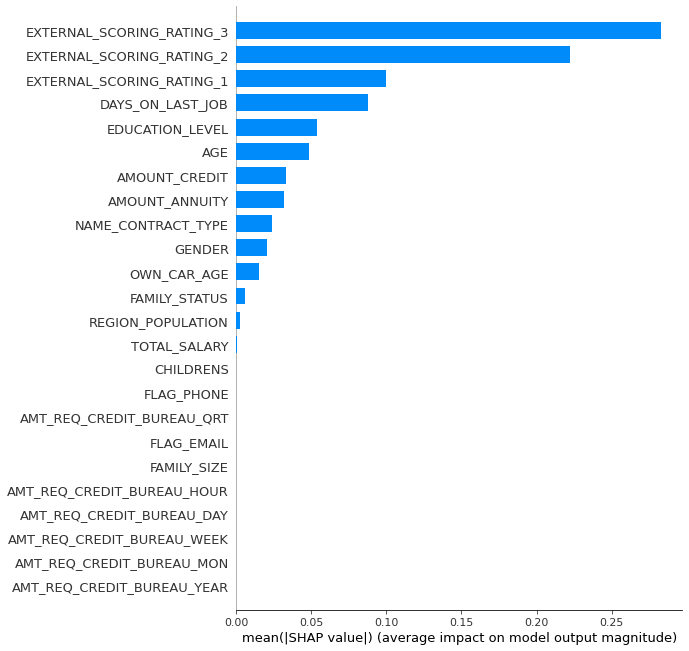

invalid value encountered in greater
invalid value encountered in less


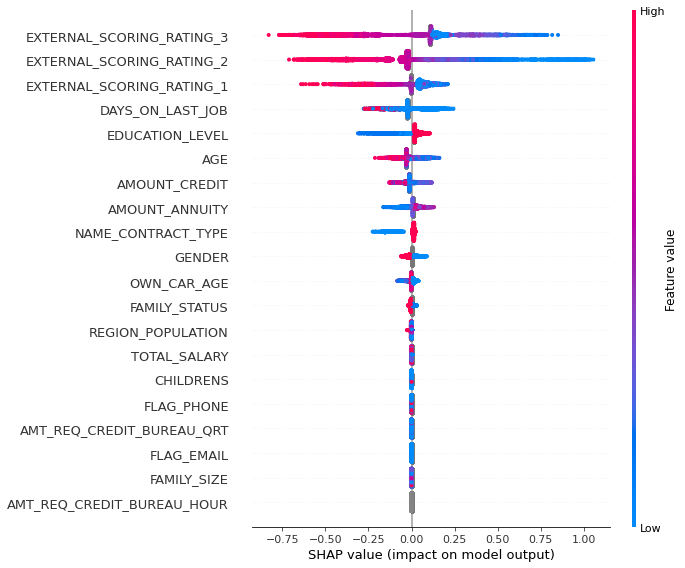

In [25]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(x_valid_, y_valid_)
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=150)
shap.summary_plot(shap_values, x_valid_, plot_type="dot")

In [26]:
mean = list()

for j in range(shap_values.shape[1]):
    bufer = 0
    for i in range(shap_values.shape[0]):
        bufer += np.abs(shap_values[i][j])
    bufer /= shap_values.shape[0]
    mean.append(bufer)

mean = np.array(mean).reshape(-1, shap_values.shape[1])

feature_importances = pd.DataFrame(mean, columns=x_valid_.columns, index=['importances'])
feature_importances = feature_importances.sort_values('importances', axis=1, ascending=0)
max_num_feature = feature_importances.loc['importances', feature_importances.loc['importances',:]>0].shape[0]
feature_high_importances = feature_importances.iloc[: ,0:max_num_feature].columns
feature_high_importances

Index(['EXTERNAL_SCORING_RATING_3', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_1', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL',
       'AGE', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'NAME_CONTRACT_TYPE',
       'GENDER', 'OWN_CAR_AGE', 'FAMILY_STATUS', 'REGION_POPULATION',
       'TOTAL_SALARY', 'CHILDRENS'],
      dtype='object')

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 6277, number of negative: 70788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 77065, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081451 -> initscore=-2.422797
[LightGBM] [Info] Start training from score -2.422797
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.722541	valid_1's auc: 0.708388
[200]	training's auc: 0.742019	valid_1's auc: 0.716331
[300]	training's auc: 0.755545	valid_1's auc: 0.719146
[400]	training's auc: 0.767135	valid_1's auc: 0.721393
[500]	training's auc: 0.77736	valid_1's auc: 0.722148
[600]	training's auc: 0.786659	valid_1's auc: 0.722682
Early stopping, best iteration is:
[561]	training's auc: 0.783119	valid_1's auc: 0.72

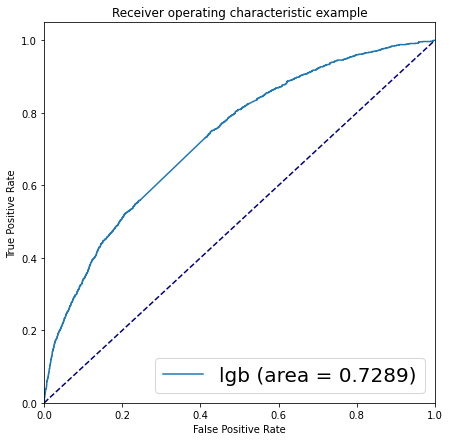

Wall time: 6.63 s


In [27]:
%%time

df_valid, df_test_ = train_test_split(df_valid, 
                                      test_size=0.5,  
                                      random_state=42)

dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

#------------------------------------------------------------------------------
#lgb
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

pred = model_lgb.predict(df_test_[feature_high_importances])
fpr, tpr, _ = roc_curve(df_test_[TARGET], pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [28]:
%%time

df_valid = df_valid.append(df_test_)

dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

[LightGBM] [Info] Number of positive: 6277, number of negative: 70788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 77065, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081451 -> initscore=-2.422797
[LightGBM] [Info] Start training from score -2.422797
Training until validation scores don't improve for 50 rounds


Found `n_estimators` in params. Will use it instead of argument


[100]	training's auc: 0.722541	valid_1's auc: 0.711407
[200]	training's auc: 0.742019	valid_1's auc: 0.719211
[300]	training's auc: 0.755545	valid_1's auc: 0.722513
[400]	training's auc: 0.767135	valid_1's auc: 0.724307
[500]	training's auc: 0.77736	valid_1's auc: 0.7253
Early stopping, best iteration is:
[468]	training's auc: 0.774484	valid_1's auc: 0.725682
Wall time: 6.22 s


In [29]:
result = model_lgb.predict(df_test[feature_high_importances])

In [30]:
df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)

df_sample_submit['TARGET'] = result

df_sample_submit.to_csv('result.csv', index=False) 

#### Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [31]:
%%time

dtrain = xgb.DMatrix(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = xgb.DMatrix(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

print('*')

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "reg_lambda": 100,
    "max_depth": 10,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model1_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=200,
    maximize=True,
)

# pred_model1_xgb = model1_xgb.predict(xgb.DMatrix(data=df_test[feature_high_importances]))

print('*'*64)


dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model1_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=200
)

# pred_model1_lgb = model1_lgb.predict(df_test[feature_high_importances])


*
[0]	train-auc:0.53916	valid-auc:0.53429
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[200]	train-auc:0.68630	valid-auc:0.68934
[400]	train-auc:0.71219	valid-auc:0.71426
[600]	train-auc:0.72225	valid-auc:0.72181
Stopping. Best iteration:
[742]	train-auc:0.72401	valid-auc:0.72345

****************************************************************
[LightGBM] [Info] Number of positive: 6277, number of negative: 70788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 77065, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081451 -> initscore=-2.422797
[LightGBM] [Info] St

In [32]:
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score

,xgb_1,lgb_1,true
xgb_1,1.000000,0.962354,0.254543
lgb_1,0.962354,1.000000,0.312403
true,0.254543,0.312403,1.000000


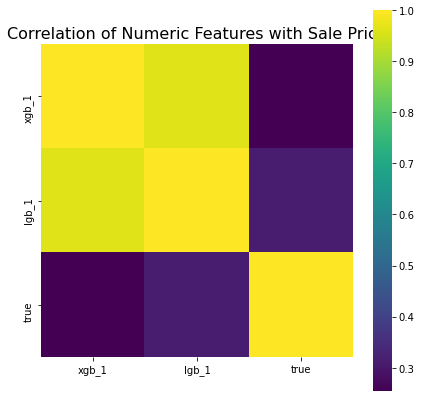

In [33]:
df_target_train = pd.DataFrame({
    "xgb_1": model1_xgb.predict(
        xgb.DMatrix(data=df_train[feature_high_importances].append(df_valid[feature_high_importances]))
    ),
    "lgb_1": model1_lgb.predict(df_train[feature_high_importances].append(df_valid[feature_high_importances])),
    "true": df_train[TARGET].append(df_valid[TARGET])
})
cor = df_target_train.corr()
fig, axes = plt.subplots(figsize = (7,7))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

cor.head()

,xgb_1,lgb_1
xgb_1,1.000000,0.964541
lgb_1,0.964541,1.000000


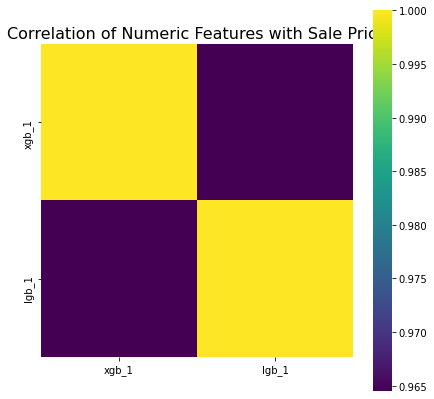

In [34]:
df_target_test = pd.DataFrame({
    "xgb_1": model1_xgb.predict(xgb.DMatrix(data=df_test[feature_high_importances])),
    "lgb_1": model1_lgb.predict(df_test[feature_high_importances])
})

cor = df_target_test.corr()
fig, axes = plt.subplots(figsize = (7,7))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")    
    
cor.head()

In [35]:
print(roc_auc_score(df_target_train['true'], df_target_train['xgb_1']))
print(roc_auc_score(df_target_train['true'], df_target_train['lgb_1']))

0.7238526914627968
0.7600740068417557


In [36]:
df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['xgb_1']
df_sample_submit.to_csv('result_xgb_1.csv', index=False) 

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['lgb_1']
df_sample_submit.to_csv('result_lgb_1.csv', index=False) 

xgb: 0.71261
lgb: 0.71692

#### Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [37]:
df_target_train['mean_'] = df_target_train.loc[:, ['xgb_1', 'lgb_1']].mean(axis=1)
df_target_train['gmean_'] = gmean(df_target_train.loc[:, ['xgb_1', 'lgb_1']], axis=1)
df_target_train['rankdata_'] = df_target_train.loc[:, ['xgb_1', 'lgb_1']].rank().mean(axis=1)

print(f"mean: {roc_auc_score(df_target_train['true'], df_target_train['mean_'])}")
print(f"gmean: {roc_auc_score(df_target_train['true'], df_target_train['gmean_'])}")
print(f"rankdata: {roc_auc_score(df_target_train['true'], df_target_train['rankdata_'])}")

mean: 0.7463345552528391
gmean: 0.7451968738478112
rankdata: 0.7432642618004526


In [38]:
df_target_test['mean_'] = df_target_test.loc[:, ['xgb_1', 'lgb_1']].mean(axis=1)
df_target_test['gmean_'] = gmean(df_target_test.loc[:, ['xgb_1', 'lgb_1']], axis=1)
df_target_test['rankdata_'] = df_target_test.loc[:, ['xgb_1', 'lgb_1']].rank().mean(axis=1)

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['mean_']
df_sample_submit.to_csv('result_mean.csv', index=False) 

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['gmean_']
df_sample_submit.to_csv('result_gmean.csv', index=False)

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['rankdata_']
df_sample_submit.to_csv('result_rankdata.csv', index=False) 

mean: 0.71618

lgb на этих данных лучше. Усреднение лучше, чем xgb, но хуже, чем lgb.

#### Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [39]:
import catboost as cb

cb_params = {
    "n_estimators": 800,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 20,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}


model_cb1 = cb.CatBoostClassifier(**cb_params)
model_cb1.fit(df_train[feature_high_importances], 
              df_train[TARGET], 
              eval_set=[(df_train[feature_high_importances], df_train[TARGET]), 
                        (df_valid[feature_high_importances], df_valid[TARGET])],
              plot=True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6425962	test1: 0.6578818	best: 0.6578818 (0)	total: 116ms	remaining: 1m 32s
20:	test: 0.6986674	test1: 0.7081070	best: 0.7082183 (19)	total: 698ms	remaining: 25.9s
40:	test: 0.7055626	test1: 0.7135404	best: 0.7143954 (38)	total: 1.32s	remaining: 24.5s
60:	test: 0.7088378	test1: 0.7169841	best: 0.7169841 (60)	total: 1.99s	remaining: 24.2s
80:	test: 0.7120248	test1: 0.7188721	best: 0.7188721 (80)	total: 2.62s	remaining: 23.2s
100:	test: 0.7145231	test1: 0.7196377	best: 0.7196377 (100)	total: 3.24s	remaining: 22.4s
120:	test: 0.7173234	test1: 0.7208469	best: 0.7208469 (120)	total: 3.88s	remaining: 21.8s
140:	test: 0.7197717	test1: 0.7218985	best: 0.7220835 (136)	total: 4.53s	remaining: 21.2s
160:	test: 0.7216897	test1: 0.7235624	best: 0.7235624 (160)	total: 5.16s	remaining: 20.5s
180:	test: 0.7236381	test1: 0.7240368	best: 0.7240897 (179)	total: 5.79s	remaining: 19.8s
200:	test: 0.7248326	test1: 0.7247620	best: 0.7247620 (200)	total: 6.41s	remaining: 19.1s
220:	test: 0.7263531	

In [40]:
df_target_train['cb_1'] = model_cb1.predict_proba(df_train[feature_high_importances].append(df_valid[feature_high_importances]))[:, 1]

,xgb_1,lgb_1,true,mean_,gmean_,rankdata_,cb_1
xgb_1,1.000000,0.962354,0.254543,0.989916,0.990783,0.806064,0.969176
lgb_1,0.962354,1.000000,0.312403,0.991152,0.990171,0.838506,0.964008
true,0.254543,0.312403,1.000000,0.287126,0.284925,0.230784,0.264464
mean_,0.989916,0.991152,0.287126,1.000000,0.999913,0.830659,0.975724
gmean_,0.990783,0.990171,0.284925,0.999913,1.000000,0.831151,0.976086


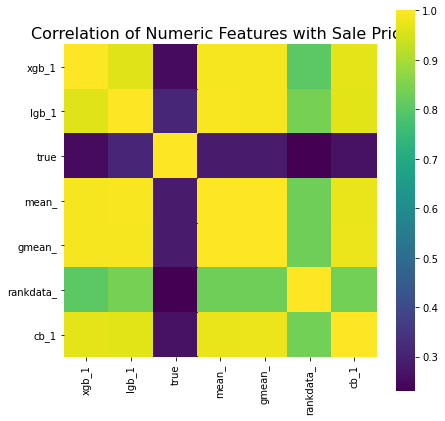

In [41]:
cor = df_target_train.corr()
fig, axes = plt.subplots(figsize = (7,7))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

cor.head()

In [42]:
print(f"cb: {roc_auc_score(df_target_train['true'], df_target_train['cb_1'])}")

cb: 0.7314480091567814


#### Выполнить задание 2 для трех моделей.

In [43]:
df_target_train['mean_3_model'] = df_target_train.loc[:, ['xgb_1', 'lgb_1', 'cb_1']].mean(axis=1)
df_target_train['gmean_3_model'] = gmean(df_target_train.loc[:, ['xgb_1', 'lgb_1', 'cb_1']], axis=1)
df_target_train['rankdata_3_model'] = df_target_train.loc[:, ['xgb_1', 'lgb_1', 'cb_1']].rank().mean(axis=1)

print(f"mean: {roc_auc_score(df_target_train['true'], df_target_train['mean_3_model'])}")
print(f"gmean: {roc_auc_score(df_target_train['true'], df_target_train['gmean_3_model'])}")
print(f"rankdata: {roc_auc_score(df_target_train['true'], df_target_train['rankdata_3_model'])}")

mean: 0.7426409295105907
gmean: 0.7416014031584297
rankdata: 0.7398390249802427


In [44]:
# mean: 0.7463345552528391
# gmean: 0.7451968738478112
# rankdata: 0.7432642618004526

In [49]:
df_target_test['cb_1'] = model_cb1.predict_proba(df_test[feature_high_importances])[:, 1]

In [51]:
df_target_test['mean_3_model'] = df_target_test.loc[:, ['xgb_1', 'lgb_1', 'cb_1']].mean(axis=1)
df_target_test['gmean_3_model'] = gmean(df_target_test.loc[:, ['xgb_1', 'lgb_1', 'cb_1']], axis=1)
df_target_test['rankdata_3_model'] = df_target_test.loc[:, ['xgb_1', 'lgb_1', 'cb_1']].rank().mean(axis=1)

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['mean_3_model']
df_sample_submit.to_csv('result_mean_3_model.csv', index=False) 

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['gmean_3_model']
df_sample_submit.to_csv('result_gmean_3_model.csv', index=False)

df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)
df_sample_submit['TARGET'] = df_target_test['rankdata_3_model']
df_sample_submit.to_csv('result_rankdata_3_model.csv', index=False) 

mean: 0.71765

Your submission scored 0.71765, which is an improvement of your previous score of 0.71761. Great job!

На тесте точность упала, зато на лидерборде подросла.